In [5]:
#The functions use eachother and the constants. It is advisable to paste the whole cell into your code, or save it as .py and import it in. 

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import numpy.random as npr
import axispi as axp

#conversion factor
con1 = 2.56819e-3 #MeV−2,  (DCS MeV-2)/con1 = DCS barns
#----------constants-------------
#Electron and Muon mass squared
mu2 = 105.658**2 #Mev^2
me2 = 0.5110**2 #Mev^2
S = 4*mu2 + 5000 #5000MeV^2 over threshold energy
alpha = 0.007297352 #no unit of measurement

def ab(s):
    #more constants to simplify calculation
    ce = 1-(4*me2/s)
    cu = 1-(4*mu2/s)
    c1 = alpha**2/(4*s)#e**4/(64 * np.pi**2 * s)
    c2 = c1 * cu**(1/2) * ce**(-1/2)

    a = c2 * (1+(4/s)*(me2+mu2))
    b = c2 * (1-(4*mu2/s)) * (1-(4*me2/s))
    return a, b


#differential cross section
def dcs(theta,s):#theta - ejection angle #s - CoM energy squared
    a,b = ab(s)
    return a+b*np.cos(theta)**2

#total cross section
def tcs(s):#s - CoM energy squared
    a,b = ab(s)
    return (4*np.pi/3)*(3*a + b)#in 1/MeV^2

#############################################################################

#probability density function, PDF of ejection angles
def pdf(theta,s):#theta - ejection angle #s - CoM energy squared
    sig = tcs(s) # daniels
    #sig = sigma(s) # mariams
    DCS = dcs(theta,s) # daniels
    #DCS = d_sigma(s,theta) # mariams
    return (2*np.pi*np.sin(theta)/sig)*DCS

#Cumulitive Density Function. Probability a THETA sampled is less than theta in the function.
def cdf(theta,s):
    a,b = ab(s)
    sig = tcs(s) # daniels
    #sig = sigma(s) # mariams
    return (2*np.pi/sig)*((-np.cos(theta)*(3*a+b*np.cos(theta)**2)*1/3)+ a)

#Theta Generation, Sampling from the PDF, Using Inverse CDF Method
def thetaGen2(howMany,s):#howMany - the number of thetas to generate #s - CoM energy squared
    #generate the lookup table for the inverse function
    theta = np.linspace(0,np.pi,100)
    CDF = [cdf(x,s) for x in theta]
    PDF = [pdf(x,s) for x in theta]
    #thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
    thetaPredictor = interp1d(CDF, theta, kind = "linear")
    return [float(thetaPredictor(x)) for x in npr.uniform(min(CDF),max(CDF),howMany)]


(array([ 33.,  80., 122., 132., 130., 151., 124., 104.,  76.,  48.]),
 array([0.07233247, 0.37026829, 0.66820412, 0.96613994, 1.26407576,
        1.56201159, 1.85994741, 2.15788324, 2.45581906, 2.75375488,
        3.05169071]),
 <BarContainer object of 10 artists>)

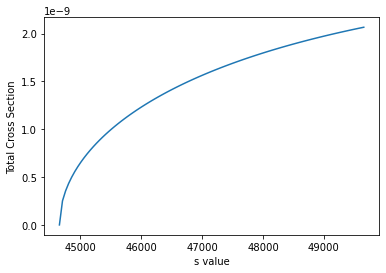

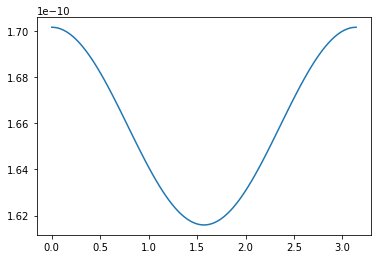

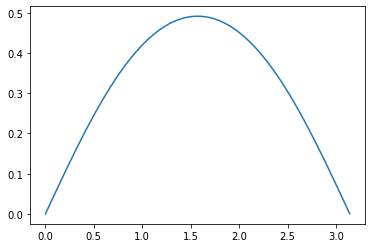

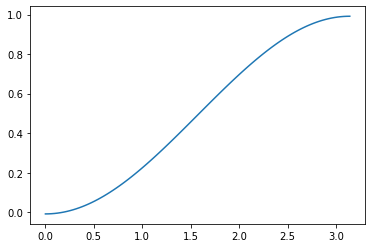

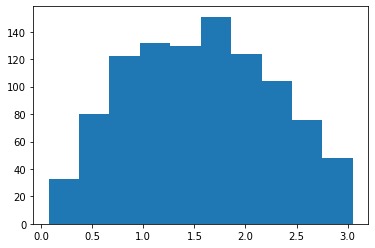

In [6]:
#Example for how to use the above functions. 

Srange = np.linspace(4*mu2,4*mu2+5000,100)
TCS = [tcs(si) for si in Senergy] #total cross section as function of energy

theta = np.linspace(0,np.pi,100) #max theta range
DCS = [dcs(th,S) for th in theta] #differential cross section
PDF = [pdf(th,S) for th in theta] #Prob Density Function
CDF = [cdf(th,S) for th in theta] #Cumulative Density Function

#
figTCS = plt.figure()
plt.plot(Srange,TCS)
plt.xlabel('s value')
plt.ylabel('Total Cross Section')

#
figDCS = plt.figure()
plt.plot(theta,DCS)
#
figPDF = plt.figure()
plt.plot(theta,PDF)
#
figCDF = plt.figure()
plt.plot(theta,CDF)
#
figThetaGen2 = plt.figure()
generatedThetas = thetaGen2(1000,S)
plt.hist(thetaGen2(1000,S))